In [3]:
import numpy as np
import cvxpy as cp

from inpainting import inpaint
from imageio import imread
import matplotlib.pyplot as plt

from itertools import product
np.random.seed(21)

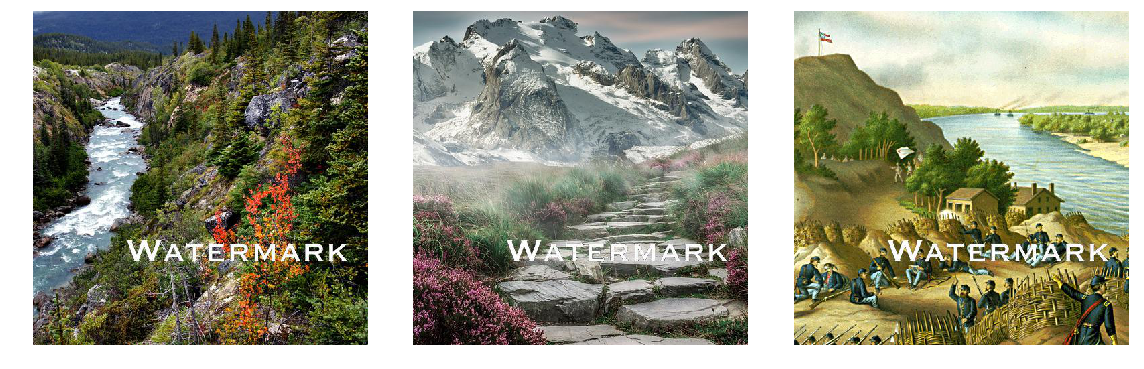

In [3]:
basedir = '/Users/jacob/Downloads/watermark/watermarked/'
fnames = [f'{basedir}stock{i}.jpg' for i in range(1, 4)]
img = [imread(fname) for fname in fnames] 

fig, ax = plt.subplots(ncols=3, figsize=(16, 16))
for i in range(3):
    ax[i].imshow(img[i])
    ax[i].set_axis_off()
    
fig.tight_layout()
plt.show()

In [4]:
def many_all(arr, axes):
    '''Apply np.all to several axes.'''
    axes = sorted(axes, key=lambda x: -x)
    for axis in axes:
        arr = np.all(arr, axis=axis)
    return arr

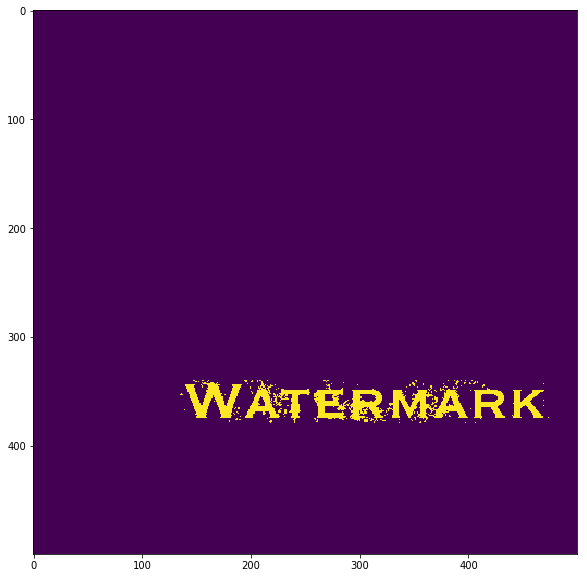

In [54]:
me = img[2]
lo = 60
hi = 256

# watermark (wm)
wm0 = (img[0] > lo) & (img[0] < hi)
wm1 = (img[1] > lo) & (img[1] < hi)
wm2 = (img[2] > lo) & (img[2] < hi)

wm = np.stack((wm0, wm1, wm2), axis=3)
wm = many_all(wm, axes=[2, 3])

mask = np.full_like(wm, False)

a1, a2, b1, b2 = 340, 380, 135, 475
mask[a1:a2, b1:b2] = True

wm = np.logical_and(wm, mask)

i, j = np.where(wm)
inds = np.stack((i, j), axis=1)

dummy = np.zeros_like(wm, np.int32)
dummy[i, j] = 255

plt.figure(figsize=(10, 10))
plt.imshow(dummy)
plt.show()

In [55]:
def nbrs(linear_inds, nrows, ncols, nsteps):
    row_offsets = np.arange(-nsteps, nsteps + 1, 1)
    col_offsets = np.arange(-nsteps * ncols, (nsteps + 1) * ncols, ncols)
    offsets = product(row_offsets, col_offsets)

    offsets = np.sum(list(offsets), axis=1)
    num_nbrs = offsets.size

    inds = np.tile(linear_inds[:, np.newaxis], num_nbrs)
    inds = inds + offsets[np.newaxis, :]
    inds = np.clip(inds, 0, nrows * ncols - 1)
    inds = inds.reshape(-1)
    return inds

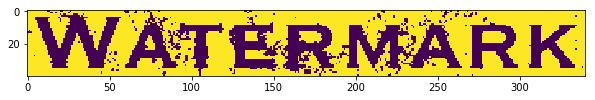

In [56]:
nrows, ncols, _ = me.shape
linear_inds = np.ravel_multi_index(inds.T, (nrows, ncols))
linear_inds = nbrs(linear_inds, nrows, ncols, nsteps=0)
i, j = np.unravel_index(linear_inds, (nrows, ncols))

temp = np.full_like(wm, True)
temp[i, j] = False

rows, cols = np.where(temp)

plt.figure(figsize=(10, 10))
plt.imshow(1 * temp[a1:a2, b1:b2])
plt.show()

In [57]:
# Only run expensive optimization on
# image crop containing watermark

cropped_me = me[a1:a2, b1:b2]
keep_rows = np.logical_and(rows >= a1, rows < a2)
keep_cols = np.logical_and(cols >= b1, cols < b2)
keep = np.logical_and(keep_rows, keep_cols)

cropped_rows = rows[keep] - a1
cropped_cols = cols[keep] - b1

In [58]:
results = []

for i in range(3):
    result = inpaint(cropped_me[..., i], cropped_rows, cropped_cols)
    results.append(result)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 194741, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 40042, constraints m = 88973
Cones:	primal zero / dual free vars: 8889
	linear vars: 80084
Setup time: 2.28e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.83e+01  1.62e+01  9.98e-01 -4.60e+07 -5.13e+04  1.64e-08  4.92e-02 
   100| 2.69e-03  3.96e-03  2.66e-03  3.31e+05  3.33e+05  5.83e-10  1.25e+00 
   200| 8.91e-04  9.69e-04  6.95e-04  3.34e+05  3.34e+05  5.88e-10  2.46e+00 
-----------------

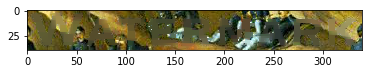

In [59]:
recovered = np.array(results, np.int32)
recovered = np.transpose(recovered, (1, 2, 0))

plt.imshow(recovered)
plt.show()

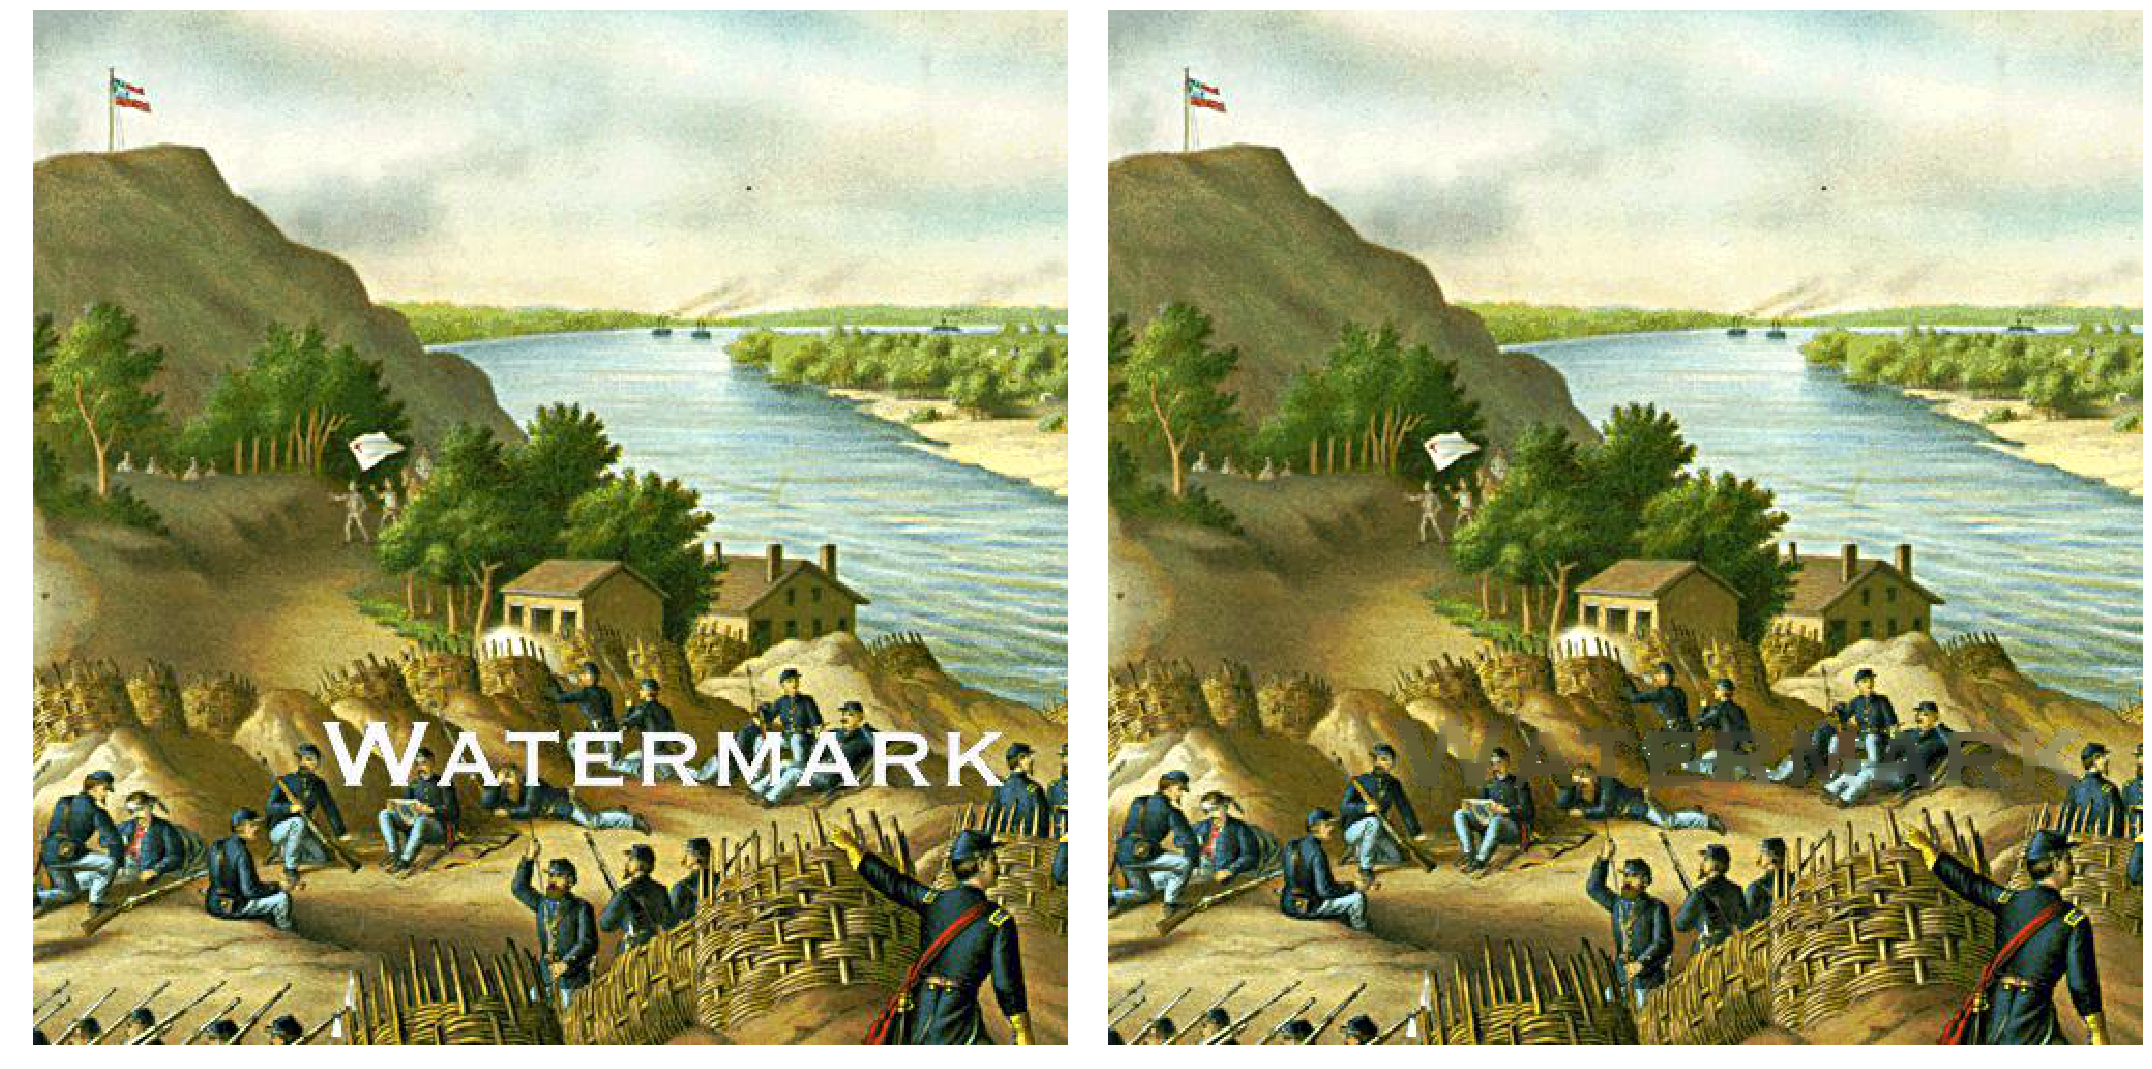

In [60]:
me_copy = me.copy()
me_copy[a1:a2, b1:b2] = recovered

fig, ax = plt.subplots(ncols=2, figsize=(30, 30))
ax[0].imshow(me)
ax[1].imshow(me_copy)
ax[0].set_axis_off()
ax[1].set_axis_off()
fig.tight_layout()
fig.savefig('/Users/jacob/Downloads/comparison.png')
plt.show()

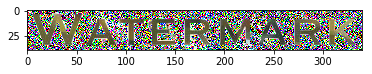

In [61]:
plt.imshow((me_copy - me)[a1:a2, b1:b2])
plt.show()